<a href="https://colab.research.google.com/github/ksulaiman1/Cassava-disease-classofication/blob/main/Cassava_classification_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import json


import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation,add
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception

In [ ]:
!ls

drive  sample_data


The dataset is stored on google drive. After mounting the google on your colab you  need to reference where your data is stored. You can check your directoey on google drive by running 
```
!ls
```
root_dir is where my data is contained


In [ ]:
#setting the data directory 

root_dir = 'drive/My Drive/Cassava Dataset' 
x = os.listdir(root_dir) #---> lists current files in a directory
print(x)

['label_num_to_disease_map.json', 'train.csv', 'train_images', 'Cassava-classification-Xception.ipynb']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(os.path.join(root_dir, 'train.csv'))
print("There are " +str(train_df.shape[0]) + "  training samples")
print(' ')
train_df.head()

There are 21397  training samples
 


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
labels_dir = os.path.join(root_dir,'label_num_to_disease_map.json')
with open(labels_dir) as f:
    mapping = json.loads(f.read())
    print(mapping)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


From the visualization we can see that CMD dominates

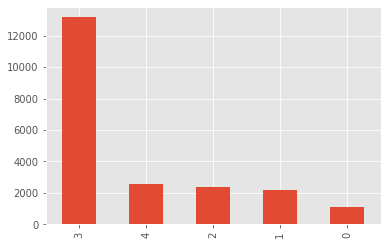

In [ ]:
train_df['label'].value_counts().plot.bar()

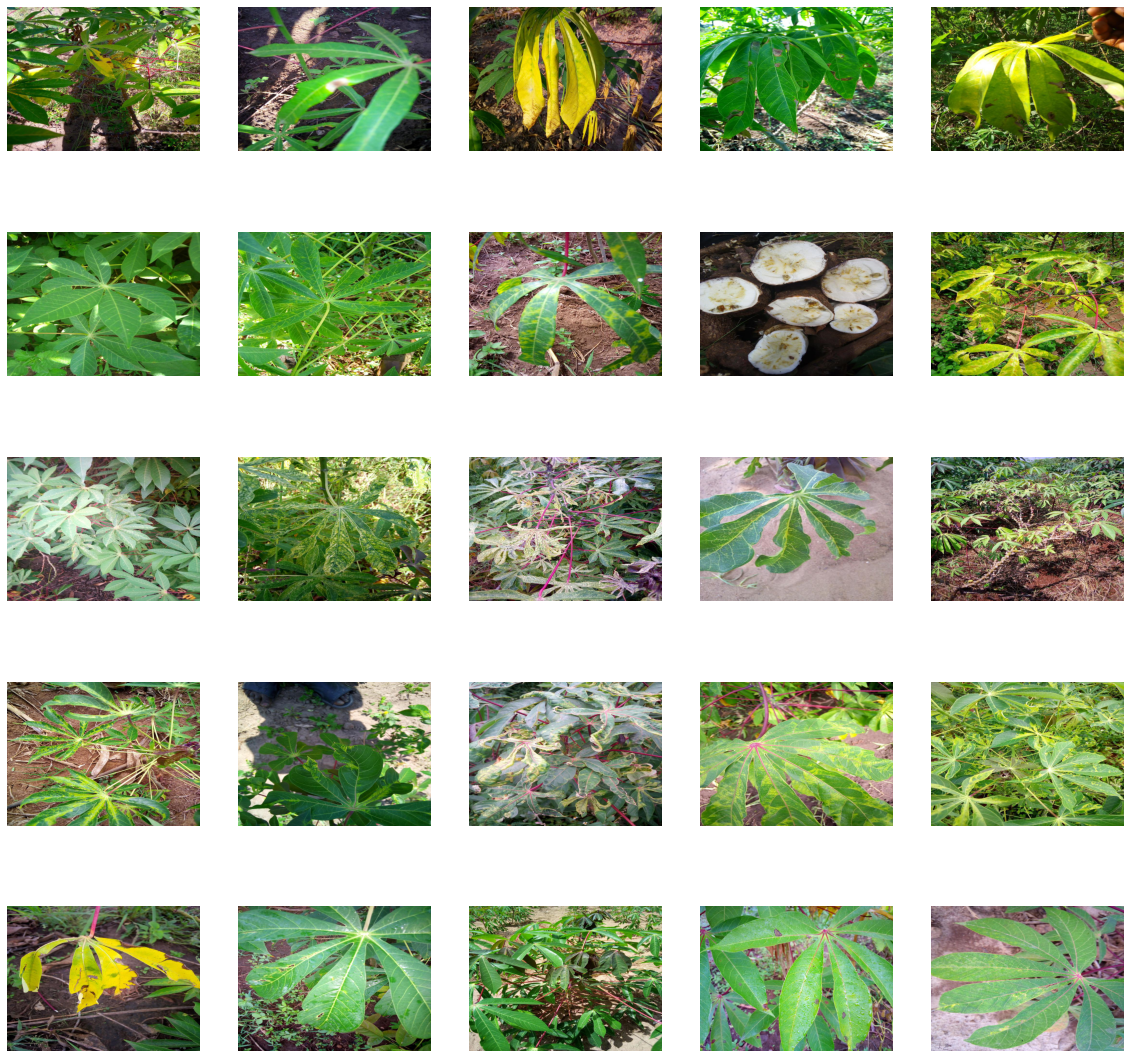

In [ ]:
train_img_dir = os.path.join(root_dir, 'train_images')

figure = plt.figure(figsize = (20,20))

cont = 0
    
for i in range(5):
    
    speci = train_df[train_df['label'] == i]
    
    for j in range(5):
        
        img = Image.open(os.path.join(train_img_dir, speci.iloc[j,0]))
        
        plt.subplot(5,5, cont+1)
        
        plt.imshow(img)
        plt.axis('off')
        
        cont = cont + 1

In [ ]:
BATCH_SIZE = 16
TARGET_SIZE = 299
EPOCHS = 15

In [ ]:
def preprocess(image):
    #Converting to numpy array
    image = np.array(image, dtype=np.uint8)
    #Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(image,(5,5),0)
    img = np.asarray(gaussian_blur, dtype=np.float64)
    return img

In [ ]:
#Convert the labels to strings so that we can use sparse_categorical
train_df.label = train_df.label.astype('str')

Read more about [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) from Keras Documentation

Read more about loading images unto Keras [here](https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Training  Augumentation
datagen = ImageDataGenerator(rescale=1.0/255,
                             featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=30,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             shear_range=15.0,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             brightness_range=[0.2, 0.8],
                             validation_split=0.2,
                             fill_mode='nearest',
                             preprocessing_function=preprocess)

#training data generator
train_datagen = datagen.flow_from_dataframe(train_df,
                                            directory = os.path.join(root_dir, "train_images"),
                                            subset = "training",
                                            x_col = "image_id",
                                            y_col = "label",
                                            target_size = (TARGET_SIZE, TARGET_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = "sparse")

#Validation data generator
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        validation_split=0.2,
                                       preprocessing_function=preprocess)


valid_datagen = validation_datagen.flow_from_dataframe(train_df,
                                            directory = os.path.join(root_dir, "train_images"),
                                            subset = "validation",
                                            x_col = "image_id",
                                            y_col = "label",
                                            target_size = (TARGET_SIZE, TARGET_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


Models available for transfer learning in Keras [Here](https://keras.io/api/applications/)

In [ ]:

base_model = Xception(weights = 'imagenet', include_top=False, input_shape = (TARGET_SIZE, TARGET_SIZE, 3), pooling=None)

base_output = base_model.output
pooling_layer = layers.GlobalAveragePooling2D()(base_output)
Dense1 = Dense(128, activation = "relu")(pooling_layer)
BN1 = BatchNormalization()(Dense1)
dropout = Dropout(0.2)(BN1)
model = Dense(5, activation="softmax")(dropout)

model = Model(base_model.input, model)

model.compile(optimizer = Adam(lr = 0.001), 
              loss = "sparse_categorical_crossentropy", 
              metrics=["acc"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Read about [ReduceLROnPlateau](https://stackoverflow.com/questions/52338090/keras-callback-reducelronplateau-cooldown-parameter)

Read about [Earlystopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

Read about [Model checkpoint](https://machinelearningmastery.com/check-point-deep-learning-models-keras/)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

filepath = "cassava_model.h5"
    
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1),
             EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)
             ]


In [ ]:
history = model.fit(train_datagen, epochs = EPOCHS, validation_data = valid_datagen)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15
1070/1070 [==============================] - 1140s 1s/step - loss: 0.8472 - acc: 0.6983 - val_loss: 0.7476 - val_acc: 0.7712
Epoch 2/15
1070/1070 [==============================] - 811s 758ms/step - loss: 0.6441 - acc: 0.7727 - val_loss: 0.9180 - val_acc: 0.6995
Epoch 3/15
1070/1070 [==============================] - 813s 760ms/step - loss: 0.5938 - acc: 0.7928 - val_loss: 2.1199 - val_acc: 0.6137
Epoch 4/15
1070/1070 [==============================] - 819s 765ms/step - loss: 0.5779 - acc: 0.7996 - val_loss: 0.7236 - val_acc: 0.7443
Epoch 5/15
1070/1070 [==============================] - 816s 763ms/step - loss: 0.5453 - acc: 0.8124 - val_loss: 0.6035 - val_acc: 0.8091
Epoch 6/15
1070/1070 [==============================] - 822s 768ms/step - loss: 0.5232 - acc: 0.8213 - val_loss: 0.7447 - val_acc: 0.7495
Epoch 7/15
1070/1070 [==============================] - 815s 761ms/step - loss: 0.5070 - acc: 0.8259 - val_loss: 0.7381 - val_acc: 0.7773
Epoch 8/15
1070/1070 [==============

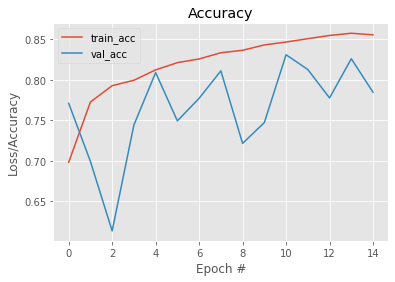

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = 8
plt.plot(np.arange(0, 15), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), history.history["val_acc"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

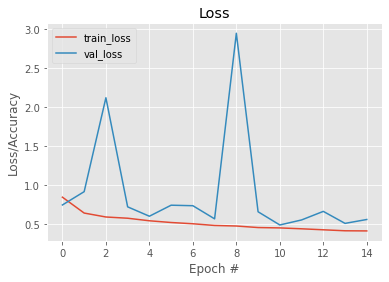

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = 8
plt.plot(np.arange(0, 15), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [ ]:
ls

sample_data/


In [ ]:
- loss: 0.4155 - acc: 0.8556 - val_loss: 0.5618 - val_acc: 0.7848